# Meta-analysis of COVID-19 papers

### Project for Management and Analysis of Physics Datasets
***

By: LamBHrusco gang



## Cluster setup

emmò la situa si complica

In [40]:
import pandas as pd
import numpy  as np 

import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:42837 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 3 Memory: 2.94 GiB


## Read of papers from JSON files

We will import JSON files and tranform them into Dask Bags

In [3]:
!head -n 4 COVID_papers/0000b93c66f991236db92dc16fa6db119b27ca12.json

{
    "paper_id": "0000b93c66f991236db92dc16fa6db119b27ca12",
    "metadata": {
        "title": "Infections in Hematopoietic Stem Cell Transplantation (HSCT) Patients 24",


In [4]:
#Read of the papers
! rm foo.bar
! ls COVID_papers >> foo.bar
#smaller dataset for various tests without the whole cluster
! rm foo2.bar
! ls COVID_papers_radio_edit >> foo2.bar

In [5]:
import dask.bag as db
import json

#b = db.read_text("foo.bar").map(lambda string: string.strip()).map(lambda string: "COVID_papers/"+string).map(open).map(json.load)
b = db.read_text("foo2.bar").map(lambda string: string.strip()).map(lambda string: "COVID_papers_radio_edit/"+string).map(open).map(json.load)

b = b.repartition(6)#select the number of partitions 
b

dask.bag<repartition, npartitions=6>

In [6]:
b.take(20)[1]['body_text'][7]['text']

"Taoism states that dynamic balance can be obtained from two opposite powers competing with each other, unifying as a complete energy. Similarly, medical informatics should be able to balance between analog medicine and digital technology to create a new value. Medicine is composed of oldfashioned values, such as rapport, which is fading out slowly. Digital technology should help clinicians restore the humanistic flavor of medicine by eliminating managerial overload in healthcare settings. Technology can start from there. Neither Cyclops (the single-eyed monster in Homer's Odyssey) nor Argus (the 100-eyed giant in Greek mythology) is ideal to find the right path. Two-eyed medical informaticians must walk through the path on the mountain ridge, carefully looking at both sides of IT and medicine for balance."

In [7]:
def concatenate_text(paper_dict):
    
    """Function to tranform the body text field of the json files into a clean and usable 
        format, by concatenating the sections and removing unwanted characters
        
        
        Arguments:
        
        paper_dict ::: python dictionary containing the paper read from the JSON files
        
        
        Returns:
        
        paper_dict ::: now the "body_text" contains all the text sections concatenated
        
        
        """
    
    body_text_list  = paper_dict['body_text'] #read of the text
    
    #concatenation of every section into one text file
    total_text = ''
    for text_section in body_text_list:
        total_text += text_section['text']
        
    total_text = total_text.lower()#lowercase everything
        
    # deteleting all unwanted characters
    
    
    forbidden_chars = ".,()[]:*><;°%/+"
    for forbidden_ch in forbidden_chars:
        
        total_text = total_text.replace(forbidden_ch,"")
        
    paper_dict['body_text'] = total_text
    
    return paper_dict
    
    
def word_count(paper_dict):
     
    """Function to count the occurencies of each word in the document using numpy functions
    
        Arguments:
        
        paper_dict ::: python dictionary containing the paper read from the JSON files
    
        
        Retrurns
        
        word_counts ::: python dictionary containing each word as key and the number of occurencies as value
    
    """
    
    import numpy as np # define right namespace
    
    body_text = paper_dict['body_text']# get the text
    text_list = body_text.split() # transform into a list
    
    words, counts = np.unique(text_list, return_counts  = True) # count the words
    
    word_counts = {key : count for key,count in zip(words, counts)} # transform into a dictionary
    #paper_dict['word_count'] = word_counts # add dictionary  to json
    
    return word_counts
    
    
    

In [8]:
def reduce_counts(word_list1,word_list2):
    
    """Combines the results od two dictionaries"""
    
    
    #obtaining the keys
    keys1 = word_list1.keys()
    keys2 = word_list2.keys()
    
    word_list_out = word_list1
    
    #add one value to the other
    for key2 in keys2:
            #check if already present
            if key2 not in keys1:
                word_list_out[key2] = word_list2[key2]
            else:
                word_list_out[key2] += word_list2[key2]
    return word_list_out
        
    
    

In [9]:
b_conc  = b.map(concatenate_text).map(word_count)
b_conc.take(2)[1]

{'"highly': 1,
 '"it\'s': 1,
 '"jack': 1,
 '"other': 1,
 '"you': 1,
 "'": 1,
 "'wakeup": 1,
 '1': 1,
 '100-eyed': 1,
 '1347': 1,
 '2': 1,
 '2003': 1,
 '2009': 1,
 '2013': 1,
 '25': 1,
 '3-tuple': 1,
 '6': 1,
 '7': 1,
 'a': 16,
 'able': 1,
 'about': 3,
 'access': 1,
 'accomplishments': 1,
 'acute': 1,
 'advances': 1,
 'advice': 1,
 'africa': 1,
 'against': 2,
 'all': 5,
 'along': 1,
 'also': 1,
 'an': 4,
 'analog': 2,
 'and': 22,
 'another': 1,
 'any': 2,
 'anybody': 1,
 'anywhere': 1,
 'applies': 1,
 'are': 1,
 'argued': 1,
 'argus': 1,
 'army': 1,
 'around': 1,
 'arrival': 1,
 'article': 1,
 'as': 7,
 'at': 3,
 'attack': 2,
 'attempts': 1,
 'attribution': 1,
 'balance': 2,
 'balancein': 1,
 'basic': 1,
 'battle': 1,
 'be': 8,
 'became': 1,
 'because': 2,
 'been': 3,
 'behavior': 1,
 'below': 1,
 'better': 1,
 'between': 1,
 'betweentaoism': 1,
 'biological': 1,
 'black': 2,
 'bleeding"': 1,
 'both': 1,
 'bound': 1,
 'bubonic': 1,
 'but': 4,
 'by': 2,
 'caffa': 1,
 'call': 1,
 'called'

In [10]:
b_conc  = b.map(concatenate_text).map(word_count)
b_count = b_conc.fold(reduce_counts)
oh = b_count.compute()

In [70]:
oh_sort = dict(sorted(oh.items(), key=lambda item: item[1])[::-1])

words_related_to_research = ['et','al','fig','data','study','number','model','results'
                             ,'figure','p','t','reported','public','table','studies','higher'
                            ,'different','population','shown','period','analysis','information']

words_related_to_COVID    = ['mers-cov','covid-19','patients','infection',
                             'rate','health','cases','virus','disease','human','pandemic',
                            'viral','autophagy','growth','response','nodules','lockdown',
                            'contact','cells','care','case','positive','protein','stem','epidemic'
                            ,'transimission','dna']

In [71]:
words_related_to_COVID

['mers-cov',
 'covid-19',
 'patients',
 'infection',
 'rate',
 'health',
 'cases',
 'virus',
 'disease',
 'human',
 'pandemic',
 'viral',
 'autophagy',
 'growth',
 'response',
 'nodules',
 'lockdown',
 'contact',
 'cells',
 'care',
 'case',
 'positive',
 'protein',
 'stem',
 'epidemic',
 'transimission',
 'dna']

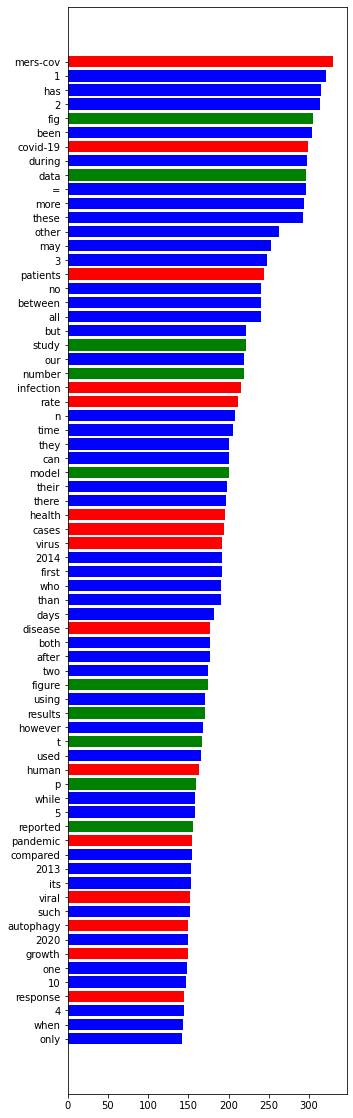

In [79]:
n_to_plot = 100
n_low = 30

list_of_vals = list(oh_sort.values())[n_low:n_to_plot]
list_of_keys = list(oh_sort.keys())[n_low:n_to_plot]

clist = []

for key in list_of_keys:
    
    if key in words_related_to_COVID:
        clist.append('red')
    elif key in words_related_to_research:
        clist.append('green')
    else:
        clist.append('blue')
    

plt.figure(figsize=[5,20])

plt.barh(list_of_keys[::-1],list_of_vals[::-1],color=clist[::-1])

#plt.xticks(rotation=60)

plt.show()

In [ ]:
##DONT LOOK AFTER THIS POINT